Titanic: Machine Learning 
https://www.kaggle.com/c/titanic/data

In [135]:
import pandas as pd
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import io
import requests
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline
import statistics as sts

In [2]:
df = pd.read_csv('data.csv')
df.shape

(891, 12)

Данные содержат 891 строк и 12 столбцов.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


в датасете пять столбцов целочисленного типа, пять типов объектов и два столбца с десятичными значениями. 

подготовим данные для машинного обучения: 

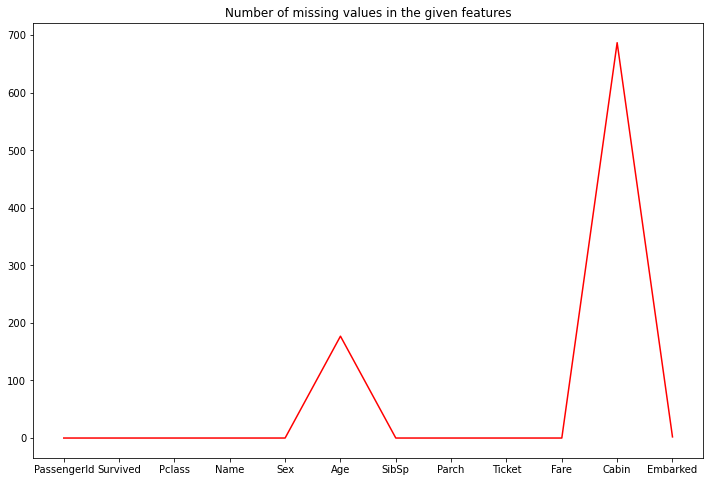

In [23]:
x = df.isnull().sum()
plt.figure(figsize=(12, 8)) 
plt.plot(x, 'r')
plt.title('Number of missing values in the given features')
plt.show()

In [25]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Линейный график и сводка показывают количество пропущенных значений во всех столбцах. 
Есть несколько столбцов, в которых отсутствуют значения:
Age            177
Cabin          687
Embarked         2

Text(0.5, 1.0, 'Missing values heatmap')

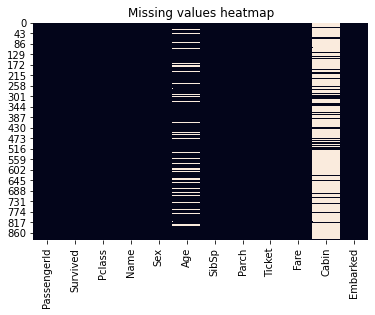

In [26]:
sns.heatmap(df.isnull(), cbar = False).set_title("Missing values heatmap")

данный график наглядно демонстрирует как много данных отстутсвует в столбцах Age и Cabin.

In [27]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

Survived и Sex может иметь два значения, Embarked и PClass имеют три различных значения
Итак, у нас есть четыре столбца данных с разделением по категориям - Survived, Sex, Embarked и PClass.

<BarContainer object of 2 artists>

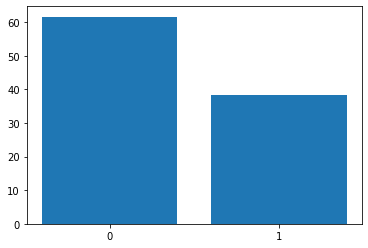

In [97]:
groups = ['0', '1']
counts = df.Survived.value_counts(normalize=True)*100
plt.bar(groups, counts)

график показывает, что более 60% людей погибли.

(-1.110415878418142, 1.100496015606113, -1.134350102435046, 1.112420061514539)

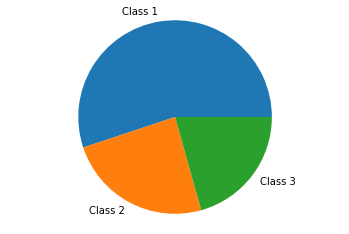

In [91]:
vals = df.Pclass.value_counts()
labels = ["Class 3","Class 1","Class 2"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels)
ax.axis("equal")

Количество пассажиров в первом классе было больше, чем количество пассажиров в первом и втором классе вместе взятых.

C:\Users\SauronGorthaur\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\SauronGorthaur\anaconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\SauronGorthaur\anaconda3\lib\site-packages\seaborn\axisgrid.py:650: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


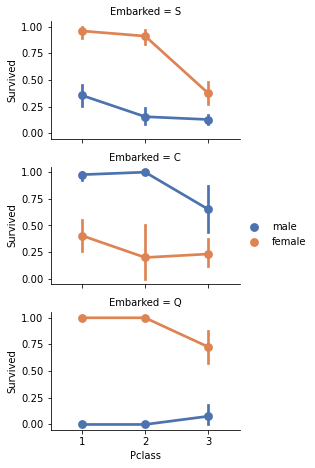

In [112]:
grid = sns.FacetGrid(df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

было спасено более 40% пассажиров первого класса. 
примерно 70% пассажиров второго класса погибли.
более 80% пассажиров третьего класса не смогли пережить катастрофу.

<BarContainer object of 2 artists>

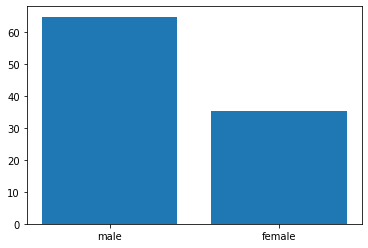

In [113]:
groups = ['male', 'female']
counts = df.Sex.value_counts(normalize=True)*100
plt.bar(groups, counts)

примерно 65% туристов составляли мужчины, а остальные 35% - женщины. 

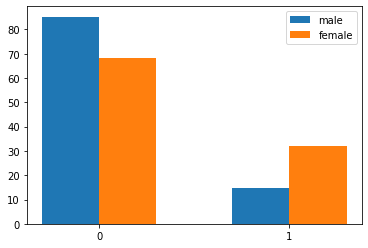

In [120]:
cat_par = ['0', '1']
g1 = df[df.Survived == 0].Sex.value_counts(normalize=True)*100
g2 = df[df.Survived == 1].Sex.value_counts(normalize=True)*100

x = np.arange(len(cat_par))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, g1, width, label='male')
rects2 = ax.bar(x + width/2, g2, width, label='female')
ax.set_xticks(x)
ax.set_xticklabels(cat_par)
ax.legend()

процент выживших среди женщин  выше, чем среди мужчин.

более 80% пассажиров-мужчин погибли, как и 70% пассажиров-женщин.

In [137]:
df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

описание столбца «Возраст» говорит о том, что самому молодому пассажиру на борту было около пяти месяцев, а самому старому пассажиру было 80 лет. Средний возраст пассажиров на борту был около 30 лет. Однако следует помнить, что в этих наблюдениях отсутствуют значения. Поскольку мы знаем, что самому старому пассажиру было 80 лет, мы можем построить график возрастного диапазона и количества людей, выживших или умерших для этого возрастного диапазона.

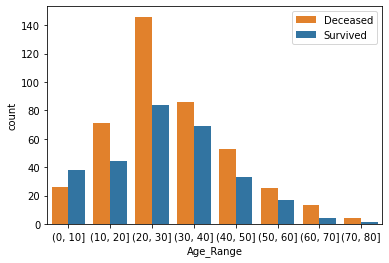

In [139]:
df['Age_Range'] = pd.cut(df.Age, [0, 10, 20, 30, 40, 50, 60,70,80])
sns.countplot(x = "Age_Range", hue = "Survived", data = df, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])

C:\Users\SauronGorthaur\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

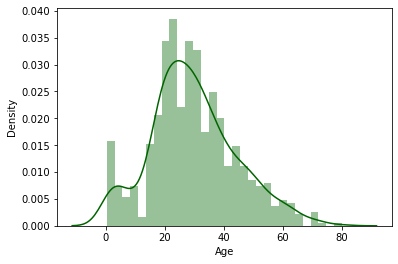

In [141]:
sns.distplot(df['Age'].dropna(),color='darkgreen',bins=30)

было спасено больше детей младше 10 лет, чем умерло. 
для всех остальных возрастных групп количество пострадавших было больше, чем количество выживших. 

SibSp - это количество братьев и сестер или супругов человека на борту.

In [143]:
df.SibSp.describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

максимум 8 братьев, сестер и супругов путешествовали вместе с одним из туристов.
более 90% людей путешествовали в одиночку или с одним из своих братьев, сестер или супругов.

Text(0.5, 1.0, 'Training Data - Number of siblings or spouses vs survival count')

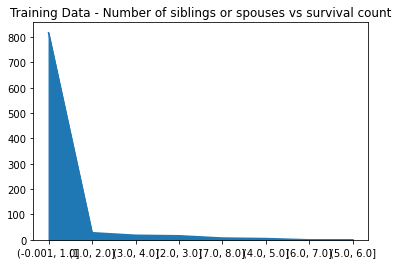

In [145]:
ss = pd.DataFrame()
ss['survived'] = df.Survived
ss['sibling_spouse'] = pd.cut(df.SibSp, [0, 1, 2, 3, 4, 5, 6,7,8], include_lowest = True)
(ss.sibling_spouse.value_counts()).plot.area().set_title("Training Data - Number of siblings or spouses vs survival count")

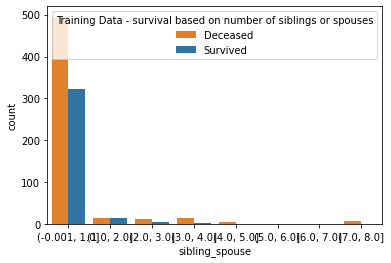

In [146]:
x = sns.countplot(x = "sibling_spouse", hue = "survived", data = ss, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Training Data - survival based on number of siblings or spouses")

In [147]:
df.Parch.describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

In [ ]:
Максимум 6 родителей / детей путешествовали вместе с одним из пассажиров.

Text(0.5, 1.0, 'Training Data - Number of parents/children and survival density')

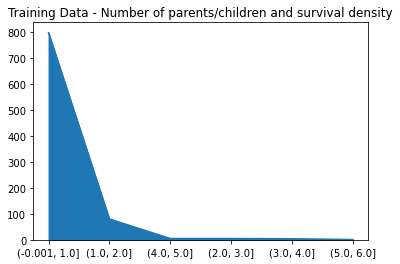

In [149]:
pc = pd.DataFrame()
pc['survived'] = df.Survived
pc['parents_children'] = pd.cut(df.Parch, [0, 1, 2, 3, 4, 5, 6], include_lowest = True)
(pc.parents_children.value_counts()).plot.area().set_title("Training Data - Number of parents/children and survival density")

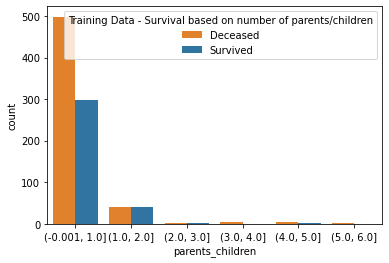

In [150]:
x = sns.countplot(x = "parents_children", hue = "survived", data = pc, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Training Data - Survival based on number of parents/children")

cоздадим два новых столбца, столбец с именем family будет содержать сумму количества братьев и сестер / супругов и количества родителей / детей.
у людей, путешествующих в одиночку, были более высокие шансы на выживание. Итак, мы также создаем столбец Is_Alone

In [153]:
df['Family'] = df.Parch + df.SibSp
df['Is_Alone'] = df.Family == 0

In [154]:
df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

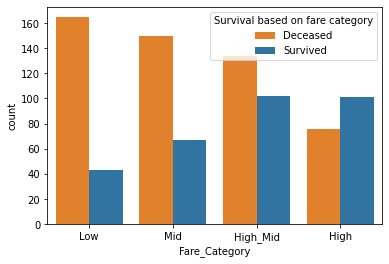

In [156]:
df['Fare_Category'] = pd.cut(df['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid','High_Mid','High'])
x = sns.countplot(x = "Fare_Category", hue = "Survived", data = df, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Survival based on fare category")

сильная корреляция между ценой за проезд и выживанием

Text(0.5, 1.0, 'Training Data - Survival based on embarking point.')

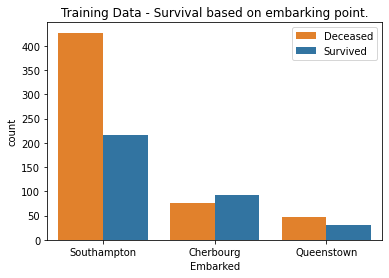

In [157]:
p = sns.countplot(x = "Embarked", hue = "Survived", data = df, palette=["C1", "C0"])
p.set_xticklabels(["Southampton","Cherbourg","Queenstown"])
p.legend(labels = ["Deceased", "Survived"])
p.set_title("Training Data - Survival based on embarking point.")

более 70% людей сели из Саутгемптона. чуть менее 20% - из Шербура, остальные - из Квинстауна.
выжило больше людей, прибывших из Шербура, чем погибших.